# Step 1: Install Necessary Libraries

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 2: Get the data

In [27]:
def apply_transform_numpy(X, transform):
    X = torch.from_numpy(X).float()
    X = X.view(-1, 1, 28, 28)  # MNIST shape
    if transform is not None:
        X = transform(X)
    return X

def get_data(
    source="torchvision",  # "torchvision" | "openml" | "csv"
    batch_size=128,
    csv_path="mnist_train.csv"
):
    if source == "torchvision":
        tv_transform = transforms.Compose([transforms.ToTensor(), lambda x: x * 2.0 - 1.0])
        dataset = MNIST(root="./data", train=True, download=True, transform=tv_transform)
    elif source == "openml":
        tensor_transform = lambda x: x * 2.0 - 1.0
        mnist = fetch_openml("mnist_784", version=1, as_frame=False)
        X = mnist["data"].astype(np.float32) / 255.0
        y = mnist["target"].astype(int)
        X = apply_transform_numpy(X, tensor_transform)
        y = torch.from_numpy(y)
        dataset = TensorDataset(X, y)
    elif source == "csv":
        tensor_transform = lambda x: x * 2.0 - 1.0
        df = pd.read_csv(csv_path)
        X = df.iloc[:, 1:].values.astype(np.float32) / 255.0
        y = df.iloc[:, 0].values
        X = apply_transform_numpy(X, tensor_transform)
        y = torch.from_numpy(y)
        dataset = TensorDataset(X, y)
    else:
        raise ValueError("source must be 'torchvision', 'openml', or 'csv'")
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [28]:
dataloader = get_data("csv")

# Step 3: Beta Schedule and Noise Schedule
Defines how much noise is added at each time step. It increases linearly over time starting with a small value and ending with a larger one.

In [29]:
T = 100  # diffusion steps

beta_start = 1e-4
beta_end = 0.02

betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1.0 - betas
alpha_bar = torch.cumprod(alphas, dim=0)

# Step 4: Forward Diffusion Process
Gradually adds Gaussian noise to the original image across many steps. The image becomes more and more noisy with each step.

In [30]:
def forward_diffusion(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_alpha_bar = torch.sqrt(alpha_bar[t])[:, None, None, None]
    sqrt_one_minus = torch.sqrt(1 - alpha_bar[t])[:, None, None, None]
    return sqrt_alpha_bar * x0 + sqrt_one_minus * noise

# Step 5: Neural Network (U Net)
Time embeddings and noise predictor (the U-Net), there is sinusoidal for faster generation and NN ones

In [31]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        # Sinusoidal embedding similar to transformers / DDPM papers
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -torch.log(torch.tensor(10000.0)) / (half_dim - 1))
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb  # [batch, dim]

In [32]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )

    def forward(self, t):
        return self.fc(t.unsqueeze(-1).float())

In [33]:
class DiffusionModel(nn.Module):
    def __init__(self, time_dim=128):
        super().__init__()
        self.time_embed = TimeEmbedding(time_dim)
        self.fc_time = nn.Linear(time_dim, 64)

        # Encoder
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Decoder / output
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 1, 3, padding=1)

        # Residual connections
        self.res_conv = nn.Conv2d(1, 64, 1)

    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_embed(t)
        t_emb = self.fc_time(t_emb)[:, :, None, None]  # shape: [B, 64, 1, 1]

        # Encoder
        h1 = F.relu(self.bn1(self.conv1(x)))
        h2 = F.relu(self.bn2(self.conv2(h1) + t_emb + self.res_conv(x)))  # residual + time
        h3 = F.relu(self.bn3(self.conv3(h2)))

        # Output noise prediction
        out = self.conv4(h3)
        return out

In [34]:
model = DiffusionModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Step 6: Training Objective (score matching)

In [35]:
def diffusion_loss(model, x0):
    batch_size = x0.size(0)
    t = torch.randint(0, T, (batch_size,), device=device)
    noise = torch.randn_like(x0)

    xt = forward_diffusion(x0, t, noise)
    noise_pred = model(xt, t)

    return F.mse_loss(noise_pred, noise)


# Step 7: Training Loop

In [36]:
epochs = 5
for epoch in range(epochs):
    total_loss = 0
    for x, _ in dataloader:
        x = x.to(device)
        loss = diffusion_loss(model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss / len(dataloader):.4f}")

Epoch 1 | Loss: 0.1726
Epoch 2 | Loss: 0.1085
Epoch 3 | Loss: 0.0986
Epoch 4 | Loss: 0.0934
Epoch 5 | Loss: 0.0889


# Step 8: Sampling (Reverse Process)
Starts from pure noise and uses the model to remove noise step by step generating a clean image at the end.

$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_T - \frac{1 - \alpha_t}{\sqrt{1 - \hat{\alpha}_t}} \epsilon_\theta(x_t, t) \right) + \sigma_t z$

In [37]:
@torch.no_grad()
def sample(model, n=16):
    model.eval()
    x = torch.randn(n, 1, 28, 28).to(device)

    for t in reversed(range(T)):
        t_batch = torch.full((n,), t, device=device, dtype=torch.long)
        noise_pred = model(x, t_batch)
        alpha = alphas[t]
        alpha_bar_t = alpha_bar[t]
        z = torch.randn_like(x) if t > 0 else 0
        x = (1 / torch.sqrt(alpha)) * (x - (1 - alpha) / torch.sqrt(1 - alpha_bar_t) * noise_pred) + torch.sqrt(betas[t]) * z

    return x

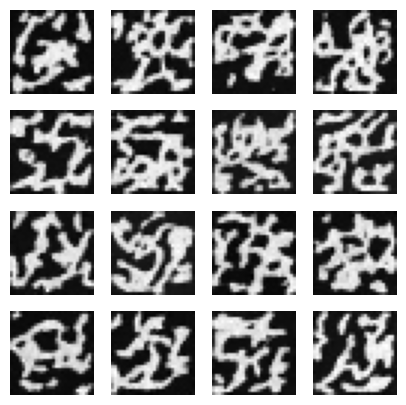

In [38]:
samples = sample(model, n=16).cpu()
samples = (samples + 1) / 2  # back to [0,1]

fig, axes = plt.subplots(4, 4, figsize=(5,5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i,0], cmap="gray")
    ax.axis("off")
plt.show()

DDIM sampling

In [39]:
@torch.no_grad()
def sample_ddim(model, n=16, steps=50):
    model.eval()
    times = torch.linspace(T-1, 0, steps).long().to(device)
    x = torch.randn(n, 1, 28, 28).to(device)

    for i in range(len(times)-1):
        t = times[i]
        t_next = times[i+1]
        t_batch = torch.full((n,), t, device=device)
        eps = model(x, t_batch)
        alpha_bar_t = alpha_bar[t]
        alpha_bar_next = alpha_bar[t_next]

        x0 = (x - torch.sqrt(1 - alpha_bar_t) * eps) / torch.sqrt(alpha_bar_t)

        x = (
            torch.sqrt(alpha_bar_next) * x0 +
            torch.sqrt(1 - alpha_bar_next) * eps
        )

    return x

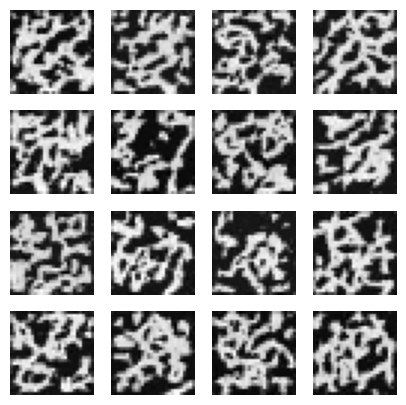

In [40]:
samples = sample_ddim(model, n=16, steps=50)
samples = (samples + 1) / 2  # back to [0,1]

fig, axes = plt.subplots(4, 4, figsize=(5,5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i,0], cmap="gray")
    ax.axis("off")
plt.show()